In [1]:
import sys
import os

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.optimize import linear_sum_assignment
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_Gamma_2_eta
from helper_funcs import log_delta_2_eta0

np.random.seed(0)
random.seed(0)

# Define parameters

In [2]:
date = "Oct-25-2022" # this is the subfolder where the results for our simulation study are held
param_folder = "../params/sim_study/" + date
plot_folder = "../plt/sim_study/" + date

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

methods = ["control","BFGS","GD","CG","SAGA","SVRG"]

tol = 1e-2
x_time = True

# Load in HMMs

In [3]:
def load_optims(T,K,d,data_set):
    
    optims = {}
    times_to_converge = {}
    epochs_to_converge = {}
    lls = {}
    
    for method in methods:
        for partial_E in partial_Es:
            if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
                pass
            else:

                # get best ll
                best_ll = -np.infty
                best_fname = param_folder + "/T-%d_K-%d-%d_d-%d_%s_%.1f_%03d_%03d" % (T,K[0],K[1],d,method,partial_E,0,data_set)

                # initialize lls
                lls[(method,partial_E)] = []

                # initialize epochs
                epochs_to_converge[(method,partial_E)] = []

                # initialize times
                times_to_converge[(method,partial_E)] = []

                for rand_seed in range(5):

                    fname = param_folder + "/T-%d_K-%d-%d_d-%d_%s_%.1f_%03d_%03d" % (T,K[0],K[1],d,method,partial_E,rand_seed,data_set)

                    try:
                        with open(fname, 'rb') as f:
                            optim = pickle.load(f)
                    except:
                        continue

                    # check for some issue (likely nan in theta)
                    if len(optim.time_trace) == 0:
                        continue

                    # get convergence ind
                    converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                       default=len(optim.grad_norm_trace)-1)

                    epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                    times_to_converge[(method,partial_E)].append(min(12.0,optim.time_trace[converge_ind] / 3600))
                    lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])

                    if optim.log_like_trace[-1] > best_ll:    
                        optims[(method,partial_E)] = optim
                        best_fname = fname
                        best_ll = optim.log_like_trace[-1]
                
    return optims,lls,epochs_to_converge,times_to_converge

# Plot Boxplots

1000 [3, 1] 3
1000 [3, 1] 6
1000 [6, 1] 3
1000 [6, 1] 6


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_37398/1420486093.py:192: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


100000 [3, 1] 3
100000 [3, 1] 6
100000 [6, 1] 3
100000 [6, 1] 6


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_37398/1420486093.py:192: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


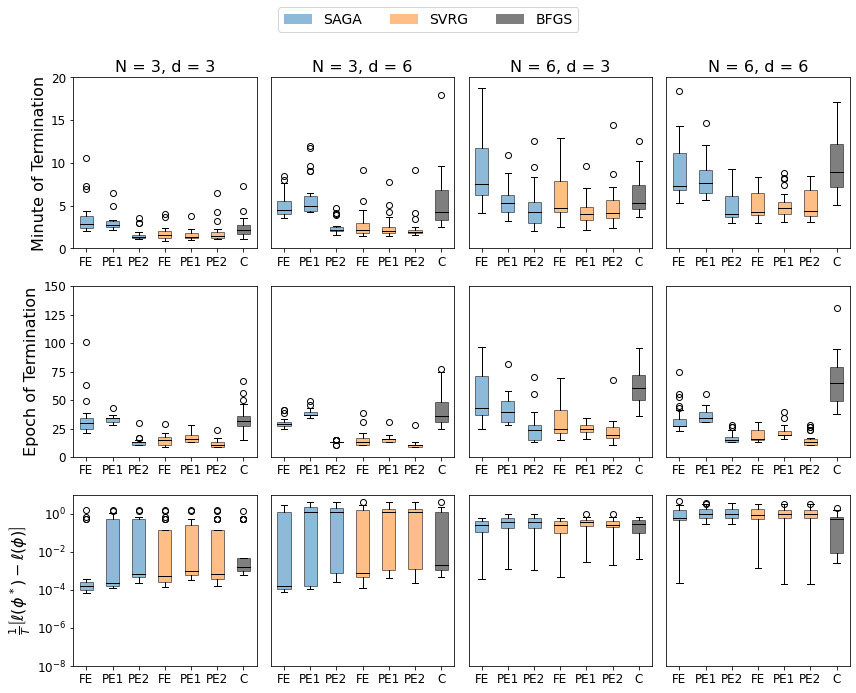

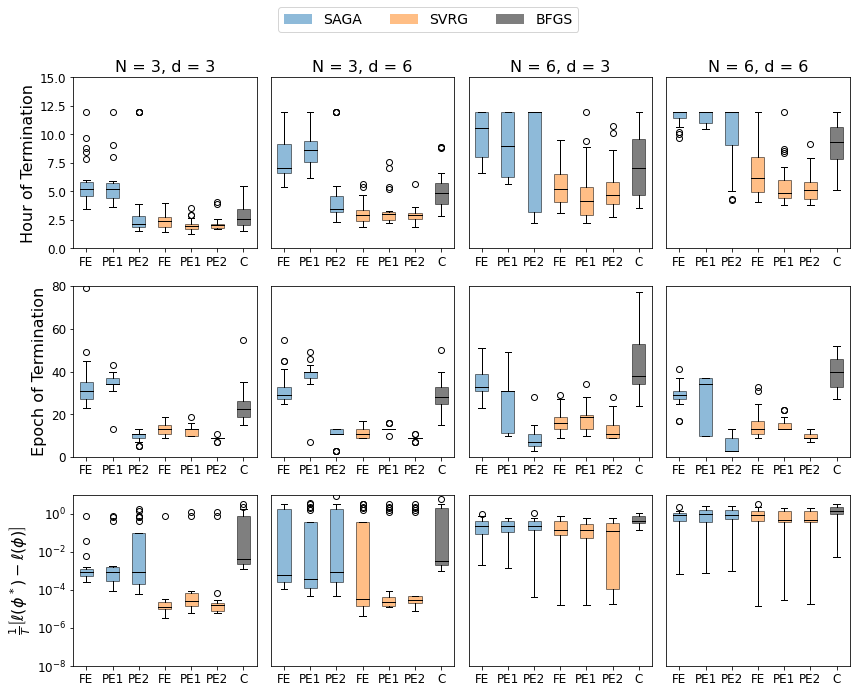

In [4]:
cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

for T in [1000,100000]:
    fig1, axs1 = plt.subplots(3,4,figsize = (12,9))
    
    for K,d in product([[3,1],[6,1]],[3,6]):

        print(T,K,d)

        yind = 0
        xind = int(d == 6) + 2*int(K[0] == 6)

        ll_star = []
        theta_star = []
        eta_star = []
        eta0_star = []

        epochs_to_converge = []
        times_to_converge = []
        lls = []

        for dataset in range(5):

            optims,lls0,epochs_to_converge0,times_to_converge0 = load_optims(T,K,d,dataset)

            ll_star.append(optims[("SAGA",0.0)].log_like_trace[-1])
            theta_star.append(optims[("SAGA",0.0)].theta)
            eta_star.append(optims[("SAGA",0.0)].eta)
            eta0_star.append(optims[("SAGA",0.0)].eta0)

            lls.append(lls0)
            epochs_to_converge.append(epochs_to_converge0)
            times_to_converge.append(times_to_converge0)

            for key in optims:

                if key[0] == 'control':
                    continue

                if ll_star[dataset] < optims[key].log_like_trace[-1]:

                    update_ll = True
                    for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                        if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                            update_ll = False
                            break

                    if update_ll:
                        ll_star[dataset] = optims[key].log_like_trace[-1]
                        theta_star[dataset] = optims[key].theta
                        eta_star[dataset] = optims[key].eta
                        eta0_star[dataset] = optims[key].eta0


        keys = [("SAGA",0.0),
                ("SAGA",0.5),
                ("SAGA",1.0),
                ("SVRG",0.0),
                ("SVRG",0.5),
                ("SVRG",1.0),
                ("BFGS",0.0)]

        labs = ["FE","PE1","PE2","FE","PE1","PE2","C"]

        epochs_to_plot = []
        times_to_plot = []
        
        for key in keys:
            key_epochs = []
            key_times = []
            for dataset in range(5):
                if T == 1000:
                    key_times.extend([60*x for x in times_to_converge[dataset][key]])
                else:
                    key_times.extend(times_to_converge[dataset][key])
                key_epochs.extend(epochs_to_converge[dataset][key])
                
            times_to_plot.append(key_times)
            epochs_to_plot.append(key_epochs)

        box = axs1[yind,xind].boxplot(times_to_plot, 
                                      whiskerprops=dict(color="black"),
                                      medianprops=dict(color="black"),
                                      patch_artist=True,
                                      labels=labs)
        
        box1 = axs1[yind+1,xind].boxplot(epochs_to_plot, 
                                         whiskerprops=dict(color="black"),
                                         medianprops=dict(color="black"),
                                         patch_artist=True,
                                         labels=labs)

        linestyles = {("BFGS",0.0):("black","-"),
                      ("CG",0.0)  :("black","--"),
                      ("GD",0.0)  :("black",":"),
                      ("SAGA",0.0):(cmap(0),"-"),
                      ("SAGA",0.5):(cmap(0),"--"),
                      ("SAGA",1.0):(cmap(0),":"),
                      ("SVRG",0.0):(cmap(1),"-"),
                      ("SVRG",0.5):(cmap(1),"--"),
                      ("SVRG",1.0):(cmap(1),":")}

        for patch, key in zip(box['boxes'], keys):
            patch.set_facecolor(linestyles[key][0])
            patch.set_alpha(0.5)
            
        for patch, key in zip(box1['boxes'], keys):
            patch.set_facecolor(linestyles[key][0])
            patch.set_alpha(0.5)

        if xind == 0:
            if T == 1000:
                axs1[yind,xind].set_ylabel("Minute of Termination",fontsize=16)
            else:
                axs1[yind,xind].set_ylabel("Hour of Termination",fontsize=16)
            axs1[yind+1,xind].set_ylabel("Epoch of Termination",fontsize=16)
        else:
            axs1[yind,xind].set_yticks([])
            axs1[yind+1,xind].set_yticks([])

        if T == 1000:
            axs1[yind,xind].set_ylim([0,20])
        else:
            axs1[yind,xind].set_ylim([0,15])

        if T == 1000:
            axs1[yind+1,xind].set_ylim([0,150])
        else:
            axs1[yind+1,xind].set_ylim([0,80])

        # set title and font sizes
        axs1[yind,xind].set_title("N = %d, d = %d" % (K[0],d), fontsize=16)
        axs1[yind,xind].tick_params(axis='both', which='major', labelsize=12)
        axs1[yind,xind].tick_params(axis='both', which='minor', labelsize=12)
        axs1[yind+1,xind].tick_params(axis='both', which='major', labelsize=12)
        axs1[yind+1,xind].tick_params(axis='both', which='minor', labelsize=12)

        #######

        yind = 2

        data_to_plot = []
        for key in keys:
            key_data = []
            for dataset in range(5):
                key_data.extend(ll_star[dataset] - lls[dataset][key])
            data_to_plot.append(key_data)

        box = axs1[yind,xind].boxplot(data_to_plot, 
                                      whiskerprops=dict(color="black"),
                                      medianprops=dict(color="black"),
                                      patch_artist=True,
                                      labels=labs)

        linestyles = {("BFGS",0.0):("black","-"),
                      ("CG",0.0)  :("black","--"),
                      ("GD",0.0)  :("black",":"),
                      ("SAGA",0.0):(cmap(0),"-"),
                      ("SAGA",0.5):(cmap(0),"--"),
                      ("SAGA",1.0):(cmap(0),":"),
                      ("SVRG",0.0):(cmap(1),"-"),
                      ("SVRG",0.5):(cmap(1),"--"),
                      ("SVRG",1.0):(cmap(1),":")}

        for patch, key in zip(box['boxes'], keys):
            patch.set_facecolor(linestyles[key][0])
            patch.set_alpha(0.5)

        axs1[yind,xind].set_yscale("log")
        axs1[yind,xind].set_ylim([1e-8,1e1])

        if xind == 0:
            axs1[yind,xind].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi^*) - \ell(\phi)\right]$",fontsize=16)
        else:
            axs1[yind,xind].set_yticks([])

        axs1[yind,xind].tick_params(axis='both', which='major', labelsize=12)
        axs1[yind,xind].tick_params(axis='both', which='minor', labelsize=12)

    legend_elements = [Patch(facecolor=cmap(0), alpha=0.5, label='SAGA'),
                       Patch(facecolor=cmap(1), alpha=0.5, label='SVRG'),
                       Patch(facecolor='black', alpha=0.5, label='BFGS')]

    fig1.legend(handles=legend_elements,
                loc='upper center',
                fontsize=14,
                bbox_to_anchor=(0.5, 1.075),
                ncol=4)

    fig1.tight_layout()
    fig1.show()

    if not os.path.isdir(plot_folder):
        os.mkdir(plot_folder)

    fig1.savefig(plot_folder + '/boxplots_sim_T_%d.png'%T,
                 dpi=500,
                 bbox_inches='tight')

# Plot scatterplots

100000 [3, 1] 3
0 0
100000 [3, 1] 6
0 1
100000 [6, 1] 3
0 2
100000 [6, 1] 6
0 3
100000 [3, 1] 3
1 0
100000 [3, 1] 6
1 1
100000 [6, 1] 3
1 2
100000 [6, 1] 6
1 3


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_37398/3808729691.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


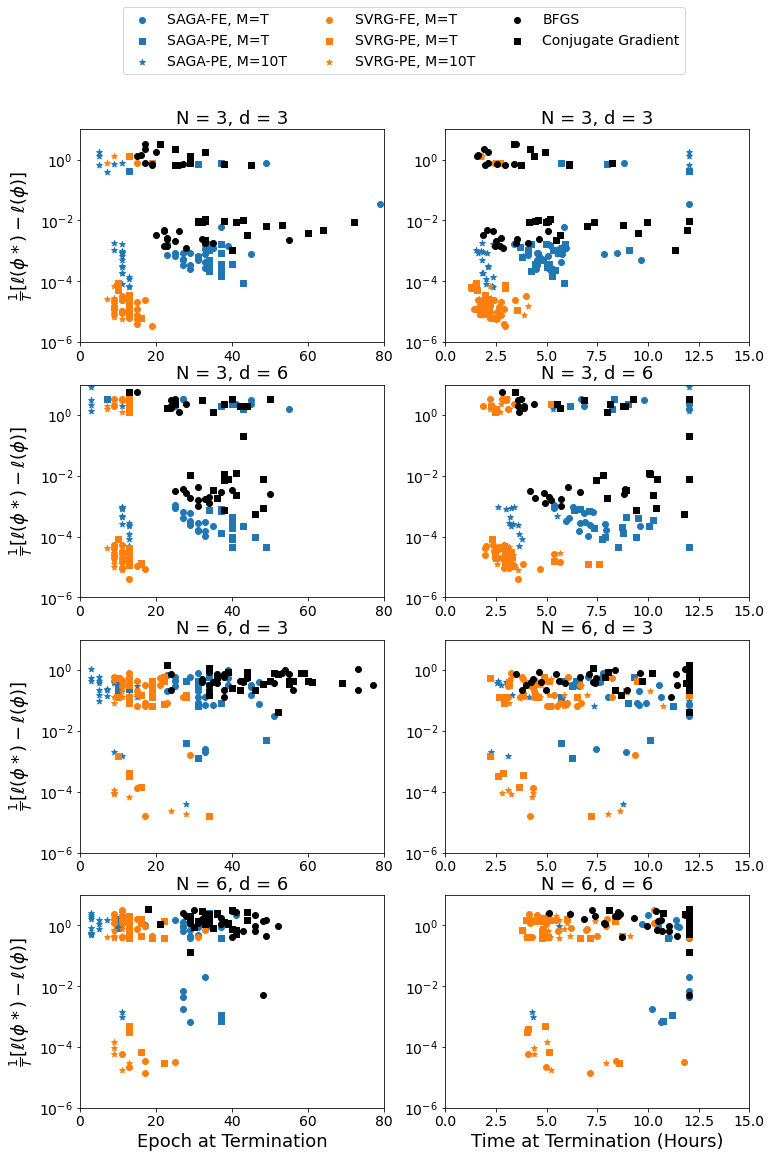

In [6]:
cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

for T in [100000]:
    fig1, axs1 = plt.subplots(4,2,figsize=(12,18))
    for x_time in [False,True]:
        for K,d in product([[3,1],[6,1]],[3,6]):

            print(T,K,d)

            xind = int(x_time)
            yind = 2*int(K[0] == 6) + int(d == 6)
            
            print(xind,yind)

            ll_star = []
            theta_star = []
            eta_star = []
            eta0_star = []

            epochs_to_converge = []
            times_to_converge = []
            lls = []

            for dataset in range(5):

                optims,lls0,epochs_to_converge0,times_to_converge0 = load_optims(T,K,d,dataset)

                ll_star.append(optims[("SAGA",0.0)].log_like_trace[-1])
                theta_star.append(optims[("SAGA",0.0)].theta)
                eta_star.append(optims[("SAGA",0.0)].eta)
                eta0_star.append(optims[("SAGA",0.0)].eta0)

                lls.append(lls0)
                epochs_to_converge.append(epochs_to_converge0)
                times_to_converge.append(times_to_converge0)

                for key in optims:

                    if key[0] == 'control':
                        continue

                    if ll_star[dataset] < optims[key].log_like_trace[-1]:

                        update_ll = True
                        for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                            if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                                update_ll = False
                                break

                        if update_ll:
                            ll_star[dataset] = optims[key].log_like_trace[-1]
                            theta_star[dataset] = optims[key].theta
                            eta_star[dataset] = optims[key].eta
                            eta0_star[dataset] = optims[key].eta0


            keys = [("SAGA",0.0),
                    ("SAGA",0.5),
                    ("SAGA",1.0),
                    ("SVRG",0.0),
                    ("SVRG",0.5),
                    ("SVRG",1.0),
                    ("BFGS",0.0),
                    ("CG",0.0)]

            # define linestyles
            linestyles = {("BFGS",0.0):("black","o"),
                          ("CG",0.0)  :("black","s"),
                          ("GD",0.0)  :("black","*"),
                          ("SAGA",0.0):(cmap(0),"o"),
                          ("SAGA",0.5):(cmap(0),"s"),
                          ("SAGA",1.0):(cmap(0),"*"),
                          ("SVRG",0.0):(cmap(1),"o"),
                          ("SVRG",0.5):(cmap(1),"s"),
                          ("SVRG",1.0):(cmap(1),"*")}

            # get data
            epochs_to_plot = []
            for key in keys:
                key_data = []
                for dataset in range(5):
                    if x_time:
                        if T == 1000:
                            key_data.extend([60*x for x in times_to_converge[dataset][key]])
                        else:
                            key_data.extend(times_to_converge[dataset][key])
                    else:
                        key_data.extend(epochs_to_converge[dataset][key])
                epochs_to_plot.append(key_data)

            lls_to_plot = []
            for key in keys:
                key_data = []
                for dataset in range(5):
                    key_data.extend(ll_star[dataset] - lls[dataset][key])
                lls_to_plot.append(key_data)

            # plot data
            for key,epoch_data,ll_data in zip(keys,epochs_to_plot,lls_to_plot):
                axs1[yind,xind].scatter(epoch_data,ll_data,
                                        color = linestyles[key][0],
                                        marker = linestyles[key][1])

            # adjust axes
            axs1[yind,xind].set_yscale('log')
            if xind == 0:
                axs1[yind,xind].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi*) - \ell(\phi)\right]$",
                                           fontsize=18)

            if yind == 3:
                if x_time:
                    if T == 1000:
                        axs1[yind,xind].set_xlabel("Time at Termination (Minutes)",fontsize=18)
                    else:
                        axs1[yind,xind].set_xlabel("Time at Termination (Hours)",fontsize=18)
                else:
                    axs1[yind,xind].set_xlabel("Epoch at Termination",fontsize=18)

            axs1[yind,xind].set_title("N = %d, d = %d" % (K[0],d), fontsize=18)

            if not x_time:
                if T == 1000:
                    axs1[yind,xind].set_xlim([0,150])
                else:
                    axs1[yind,xind].set_xlim([0,80])
            else:
                if T == 1000:
                    axs1[yind,xind].set_xlim([0,20])
                else:
                    axs1[yind,xind].set_xlim([0,15])

            axs1[yind,xind].set_ylim([1e-6,1e1])

            axs1[yind,xind].tick_params(axis='both', which='major', labelsize=14)
            axs1[yind,xind].tick_params(axis='both', which='minor', labelsize=14)

    legend_elem = {("BFGS",0.0): "BFGS",
                   ("CG",0.0)  : "Conjugate Gradient",
                   ("GD",0.0)  : "GD",
                   ("SVRG",0.0): "SVRG-FE, M=T",
                   ("SVRG",0.5): "SVRG-PE, M=T",
                   ("SVRG",1.0): "SVRG-PE, M=10T",
                   ("SAGA",0.0): "SAGA-FE, M=T",
                   ("SAGA",0.5): "SAGA-PE, M=T",
                   ("SAGA",1.0): "SAGA-PE, M=10T"}
    # make legend
    fig1.legend([legend_elem[key] for key in keys],
                loc='upper center', 
                fontsize=14,
                bbox_to_anchor=(0.5, 0.98),
                ncol=3)

    if not os.path.isdir(plot_folder):
        os.mkdir(plot_folder)

    fig1.savefig(plot_folder + '/scatter_sim_T_%d.png'%T,
                 dpi=500,
                 bbox_inches='tight')

    fig1.show()

1000 [3, 1] 3
1000 [3, 1] 6
1000 [6, 1] 3
1000 [6, 1] 6


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_37398/2291271945.py:164: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


100000 [3, 1] 3
100000 [3, 1] 6
100000 [6, 1] 3
100000 [6, 1] 6
1000 [3, 1] 3
1000 [3, 1] 6
1000 [6, 1] 3
1000 [6, 1] 6
100000 [3, 1] 3
100000 [3, 1] 6
100000 [6, 1] 3
100000 [6, 1] 6


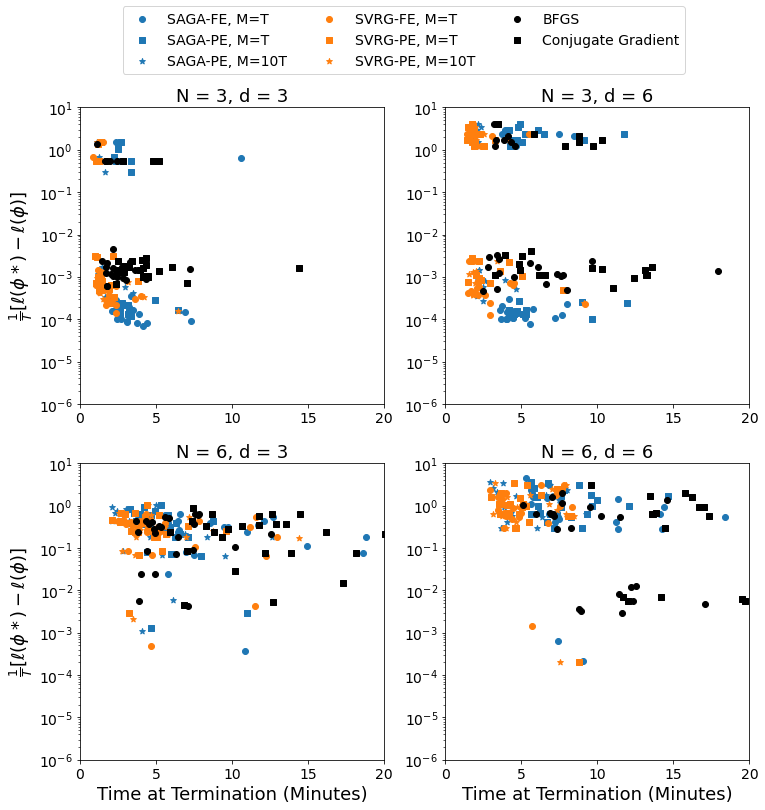

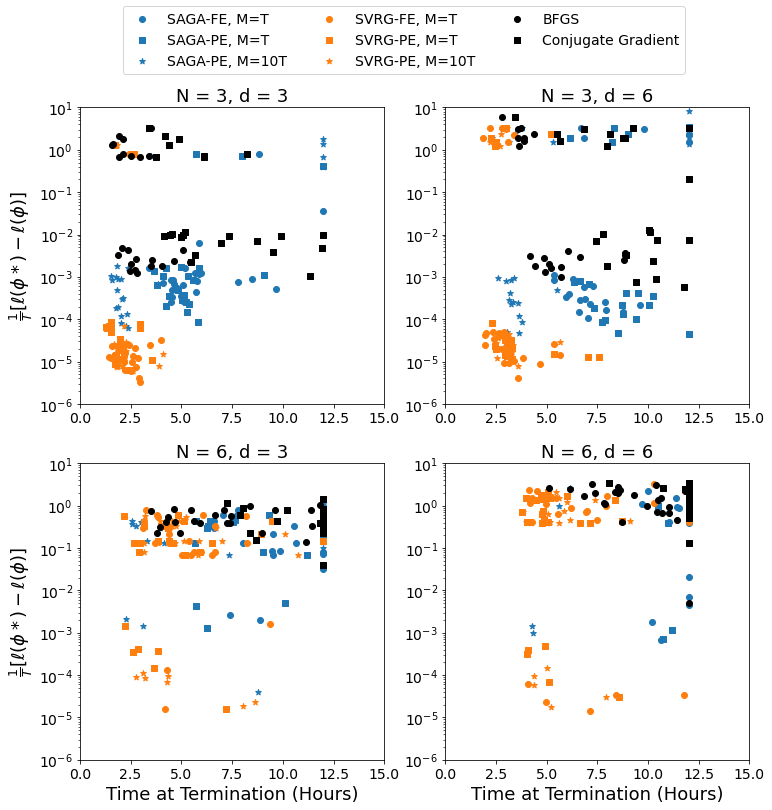

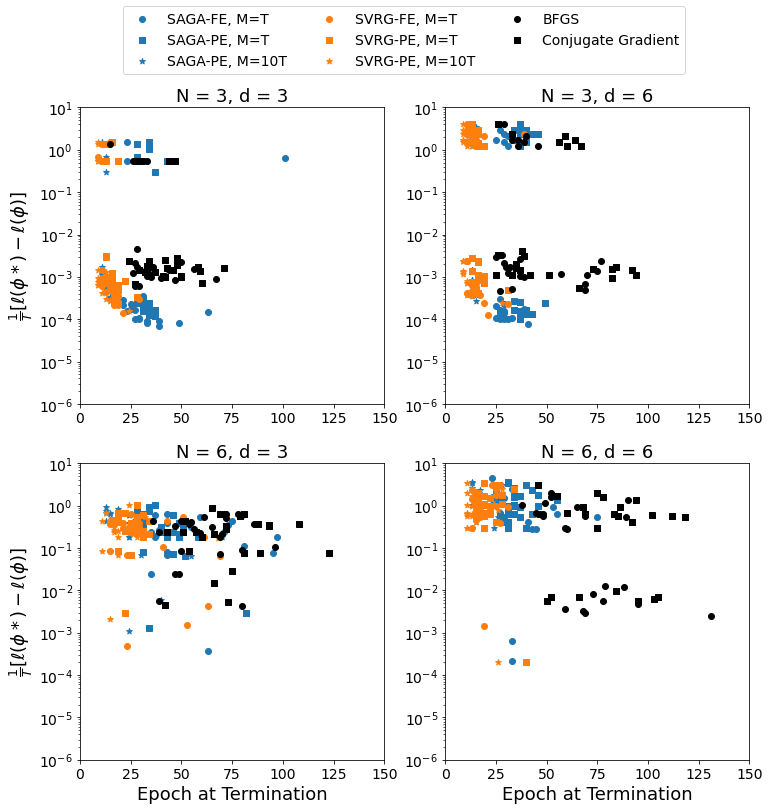

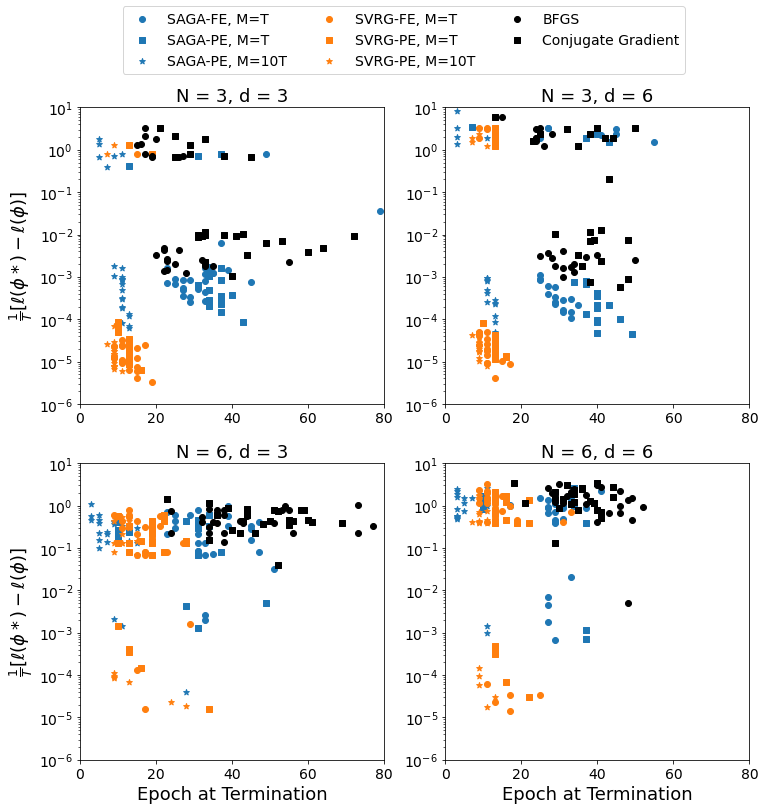

In [12]:
cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

for x_time in [True,False]:
    for T in [1000,100000]:
        fig1, axs1 = plt.subplots(2,2,figsize=(12,12))
        for K,d in product([[3,1],[6,1]],[3,6]):

            print(T,K,d)

            yind = int(K[0] == 6)
            xind = int(d == 6)

            ll_star = []
            theta_star = []
            eta_star = []
            eta0_star = []

            epochs_to_converge = []
            times_to_converge = []
            lls = []

            for dataset in range(5):

                optims,lls0,epochs_to_converge0,times_to_converge0 = load_optims(T,K,d,dataset)

                ll_star.append(optims[("SAGA",0.0)].log_like_trace[-1])
                theta_star.append(optims[("SAGA",0.0)].theta)
                eta_star.append(optims[("SAGA",0.0)].eta)
                eta0_star.append(optims[("SAGA",0.0)].eta0)

                lls.append(lls0)
                epochs_to_converge.append(epochs_to_converge0)
                times_to_converge.append(times_to_converge0)

                for key in optims:

                    if key[0] == 'control':
                        continue

                    if ll_star[dataset] < optims[key].log_like_trace[-1]:

                        update_ll = True
                        for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                            if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                                update_ll = False
                                break

                        if update_ll:
                            ll_star[dataset] = optims[key].log_like_trace[-1]
                            theta_star[dataset] = optims[key].theta
                            eta_star[dataset] = optims[key].eta
                            eta0_star[dataset] = optims[key].eta0


            keys = [("SAGA",0.0),
                    ("SAGA",0.5),
                    ("SAGA",1.0),
                    ("SVRG",0.0),
                    ("SVRG",0.5),
                    ("SVRG",1.0),
                    ("BFGS",0.0),
                    ("CG",0.0)]

            # define linestyles
            linestyles = {("BFGS",0.0):("black","o"),
                          ("CG",0.0)  :("black","s"),
                          ("GD",0.0)  :("black","*"),
                          ("SAGA",0.0):(cmap(0),"o"),
                          ("SAGA",0.5):(cmap(0),"s"),
                          ("SAGA",1.0):(cmap(0),"*"),
                          ("SVRG",0.0):(cmap(1),"o"),
                          ("SVRG",0.5):(cmap(1),"s"),
                          ("SVRG",1.0):(cmap(1),"*")}

            # get data
            epochs_to_plot = []
            for key in keys:
                key_data = []
                for dataset in range(5):
                    if x_time:
                        if T == 1000:
                            key_data.extend([60*x for x in times_to_converge[dataset][key]])
                        else:
                            key_data.extend(times_to_converge[dataset][key])
                    else:
                        key_data.extend(epochs_to_converge[dataset][key])
                epochs_to_plot.append(key_data)

            lls_to_plot = []
            for key in keys:
                key_data = []
                for dataset in range(5):
                    key_data.extend(ll_star[dataset] - lls[dataset][key])
                lls_to_plot.append(key_data)

            # plot data
            for key,epoch_data,ll_data in zip(keys,epochs_to_plot,lls_to_plot):
                axs1[yind,xind].scatter(epoch_data,ll_data,
                                        color = linestyles[key][0],
                                        marker = linestyles[key][1])

            # adjust axes
            axs1[yind,xind].set_yscale('log')
            if xind == 0:
                axs1[yind,xind].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi*) - \ell(\phi)\right]$",
                                           fontsize=18)

            if yind == 1:
                if x_time:
                    if T == 1000:
                        axs1[yind,xind].set_xlabel("Time at Termination (Minutes)",fontsize=18)
                    else:
                        axs1[yind,xind].set_xlabel("Time at Termination (Hours)",fontsize=18)
                else:
                    axs1[yind,xind].set_xlabel("Epoch at Termination",fontsize=18)

            axs1[yind,xind].set_title("N = %d, d = %d" % (K[0],d), fontsize=18)

            if not x_time:
                if T == 1000:
                    axs1[yind,xind].set_xlim([0,150])
                else:
                    axs1[yind,xind].set_xlim([0,80])
            else:
                if T == 1000:
                    axs1[yind,xind].set_xlim([0,20])
                else:
                    axs1[yind,xind].set_xlim([0,15])

            axs1[yind,xind].set_ylim([1e-6,1e1])

            axs1[yind,xind].tick_params(axis='both', which='major', labelsize=14)
            axs1[yind,xind].tick_params(axis='both', which='minor', labelsize=14)

        legend_elem = {("BFGS",0.0): "BFGS",
                       ("CG",0.0)  : "Conjugate Gradient",
                       ("GD",0.0)  : "GD",
                       ("SVRG",0.0): "SVRG-FE, M=T",
                       ("SVRG",0.5): "SVRG-PE, M=T",
                       ("SVRG",1.0): "SVRG-PE, M=10T",
                       ("SAGA",0.0): "SAGA-FE, M=T",
                       ("SAGA",0.5): "SAGA-PE, M=T",
                       ("SAGA",1.0): "SAGA-PE, M=10T"}
        # make legend
        fig1.legend([legend_elem[key] for key in keys],
                    loc='upper center', 
                    fontsize=14,
                    bbox_to_anchor=(0.5, 1.005),
                    ncol=3)

        if not os.path.isdir(plot_folder):
            os.mkdir(plot_folder)

        if x_time:
            fig1.savefig(plot_folder + '/scatter_sim_T_%d_time.png'%T,
                         dpi=500,
                         bbox_inches='tight')
        else:
            fig1.savefig(plot_folder + '/scatter_sim_T_%d_epoch.png'%T,
                         dpi=500,
                         bbox_inches='tight')    

        fig1.show()

# Plot Log-Likelihood

In [8]:
cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

In [9]:
def get_ll_star(optims):
    
    ll_star = optims[("SAGA",0.0)].log_like_trace[-1]

    for key in optims:

        if key[0] == 'control':
            continue

        if ll_star < optims[key].log_like_trace[-1]:

            update_ll = True
            for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                    update_ll = False
                    break

            if update_ll:
                ll_star = optims[key].log_like_trace[-1]

    return ll_star

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


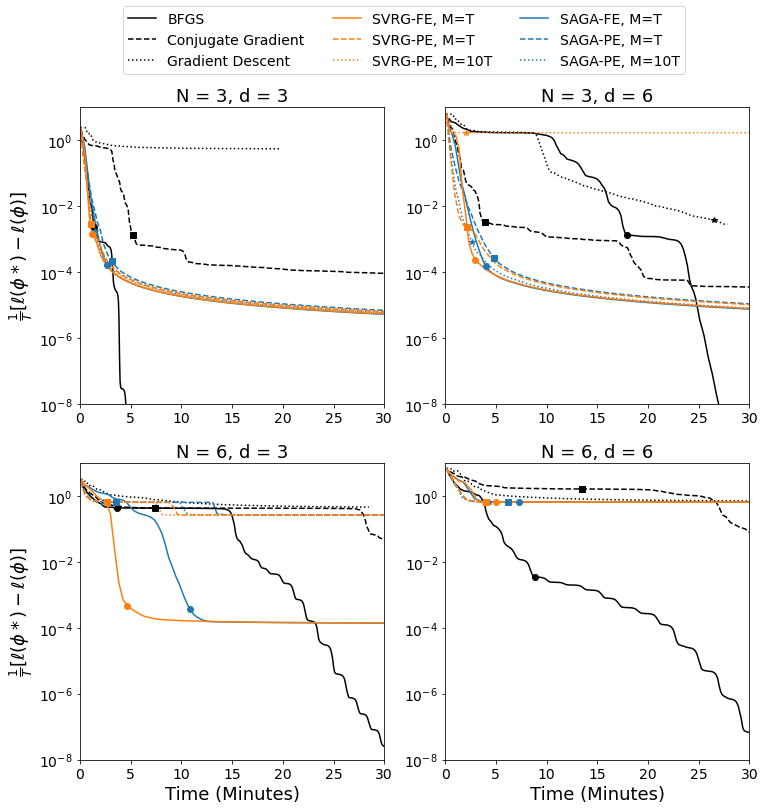

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


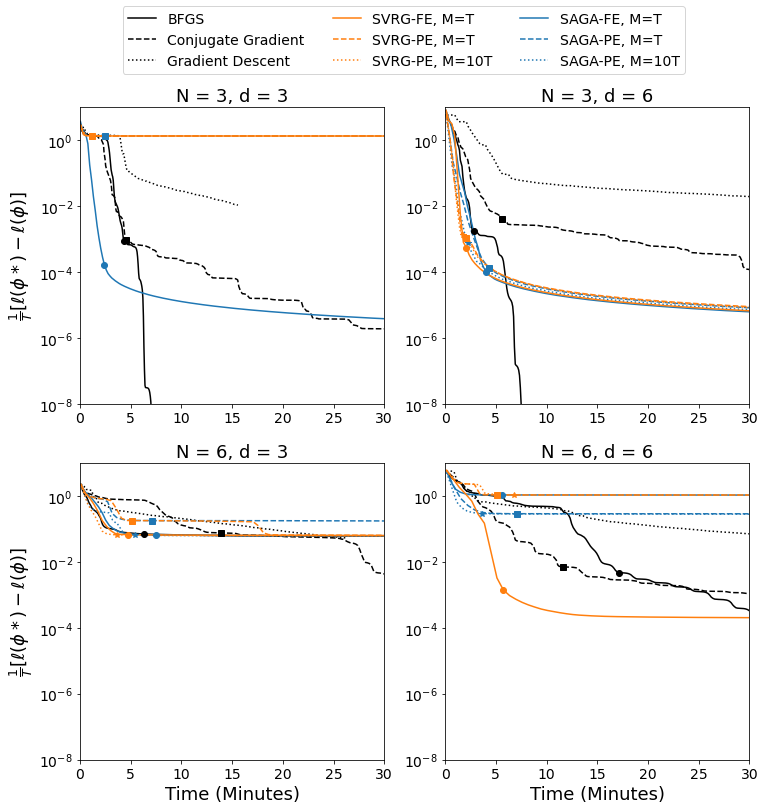

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


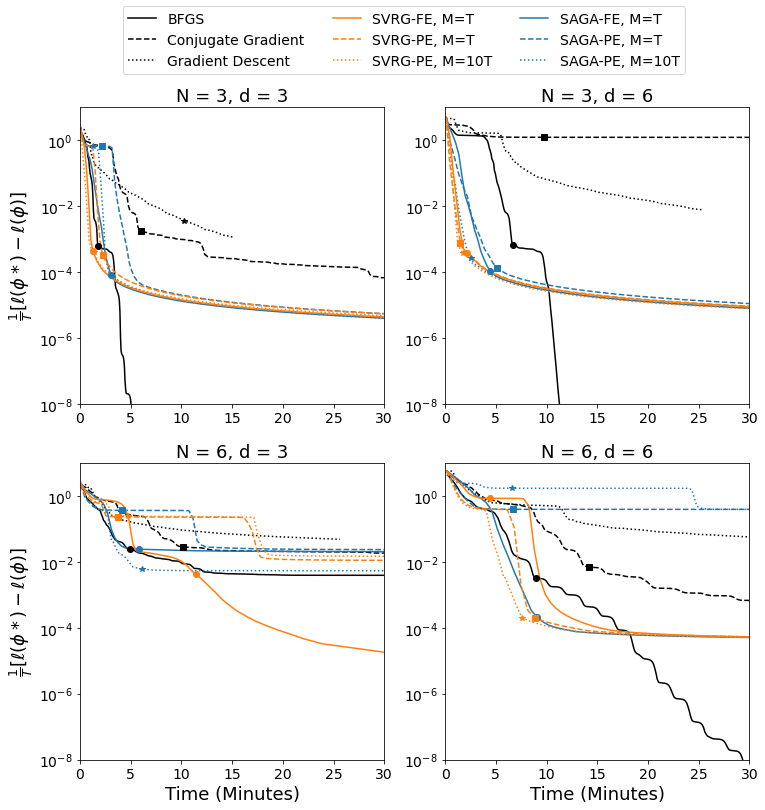

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


KeyboardInterrupt: 

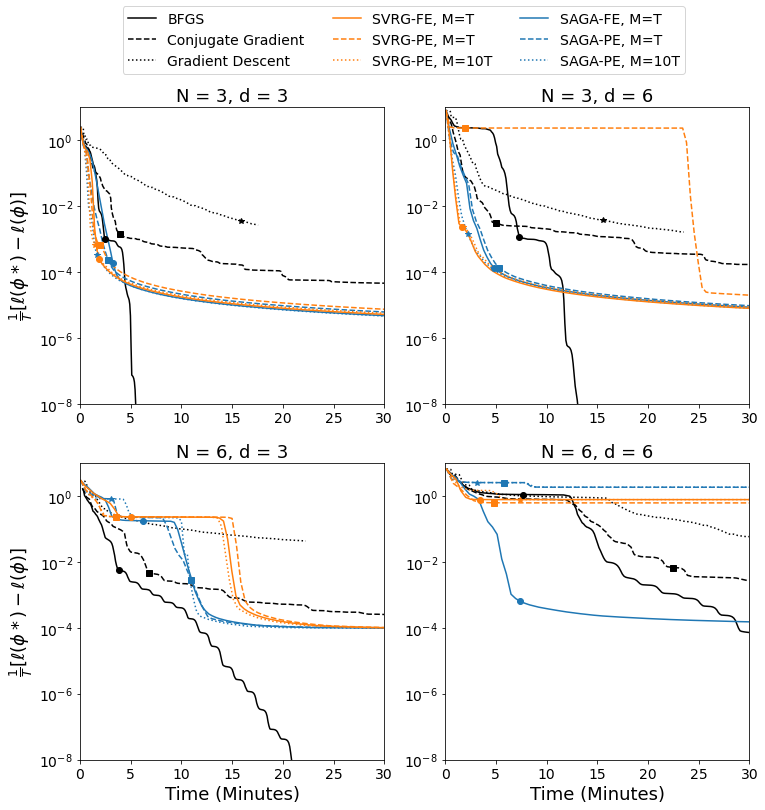

In [10]:
# get plotting parameters

cmap = cm.get_cmap('tab10')

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

pointstyles = {("BFGS",0.0):("black","o"),
               ("CG",0.0)  :("black","s"),
               ("GD",0.0)  :("black","*"),
               ("SVRG",0.0):(cmap(1),"o"),
               ("SVRG",0.5):(cmap(1),"s"),
               ("SVRG",1.0):(cmap(1),"*"),
               ("SAGA",0.0):(cmap(0),"o"),
               ("SAGA",0.5):(cmap(0),"s"),
               ("SAGA",1.0):(cmap(0),"*")}

labels = {("BFGS",0.0): "BFGS",
          ("CG",0.0)  : "Conjugate Gradient",
          ("GD",0.0)  : "Gradient Descent",
          ("SVRG",0.0): "SVRG-FE, M=T",
          ("SVRG",0.5): "SVRG-PE, M=T",
          ("SVRG",1.0): "SVRG-PE, M=10T",
          ("SAGA",0.0): "SAGA-FE, M=T",
          ("SAGA",0.5): "SAGA-PE, M=T",
          ("SAGA",1.0): "SAGA-PE, M=10T"}

legend_elements = []

for key in labels:
    legend_elements.append(Line2D([0], [0], 
                                  color=linestyles[key][0], 
                                  linestyle=linestyles[key][1], 
                                  label=labels[key]))

xlims = None
ylims = None
max_epoch = 500

for x_time in [True,False]:
    for T in [1000,100000]:
        for dataset in range(5):

            fig, axs = plt.subplots(2,2,figsize = (12,12))

            for xind,d in enumerate([3,6]):
                for yind,K in enumerate([[3,1],[6,1]]):

                    print(K,d)

                    optims,lls,epochs_to_converge,times_to_converge = load_optims(T,K,d,dataset)
                    ll_star = get_ll_star(optims)

                    for method in methods:

                        if method == 'control':
                            continue

                        for partial_E in [0,0.5,1]:

                            if (method,partial_E) in optims:

                                optim = optims[(method,partial_E)]
                                eind = min(np.where(np.array(optim.epoch_trace) >= max_epoch)[0],
                                           default=len(optim.grad_norm_trace))

                                if x_time:
                                    if T == 100000:
                                        time_trace = [min(12.0,x/3600) for x in optim.time_trace]
                                    else:
                                        time_trace = [x/60 for x in optim.time_trace]

                                    axs[yind,xind].plot(time_trace[:eind],
                                                        ll_star-optim.log_like_trace[:eind],
                                                        color=linestyles[(method,partial_E)][0],
                                                        linestyle=linestyles[(method,partial_E)][1])
                                else:
                                    axs[yind,xind].plot(optim.epoch_trace[:eind],
                                                        ll_star-optim.log_like_trace[:eind],
                                                        color=linestyles[(method,partial_E)][0],
                                                        linestyle=linestyles[(method,partial_E)][1])

                    # add points
                    max_x = 0
                    min_y = 1e-4

                    for method in methods:
                        if method == 'control':
                            continue
                        for partial_E in [0,0.5,1]:
                            if (method,partial_E) in optims:
                                optim = optims[(method,partial_E)]
                                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                                   default=len(optim.grad_norm_trace)-1)
                                eind = min(np.where(np.array(optim.epoch_trace) >= max_epoch)[0],
                                           default=len(optim.grad_norm_trace))

                                if converge_ind > eind:
                                    continue

                                if method != 'GD':
                                    if optim.epoch_trace[converge_ind] > max_x:
                                        max_x = optim.epoch_trace[converge_ind]
                                    if ll_star-optim.log_like_trace[converge_ind] < min_y:
                                        min_y = ll_star-optim.log_like_trace[converge_ind]

                                if x_time:
                                    if T == 100000:
                                        time_trace = optim.time_trace[converge_ind]/3600
                                    else:
                                        time_trace = optim.time_trace[converge_ind]/60
                                    axs[yind,xind].plot(time_trace,
                                                        ll_star-optim.log_like_trace[converge_ind],
                                                        color = pointstyles[(method,partial_E)][0],
                                                        marker = pointstyles[(method,partial_E)][1])
                                else:
                                    axs[yind,xind].plot(optim.epoch_trace[converge_ind],
                                                        ll_star-optim.log_like_trace[converge_ind],
                                                        color = pointstyles[(method,partial_E)][0],
                                                        marker = pointstyles[(method,partial_E)][1])

                    if not xlims is None:
                        axs[yind,xind].set_xlim(xlims)
                    if not ylims is None:
                        axs[yind,xind].set_ylim(ylims)

                    axs[yind,xind].set_yscale("log")
                    axs[yind,xind].set_title("N = %d, d = %d" % (K[0],d),fontsize=18)

                    if xind == 0:
                        axs[yind,xind].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi*) - \ell(\phi)\right]$",fontsize=18)

                    if yind == 1:
                        if x_time: 
                            if T == 100000:
                                axs[yind,xind].set_xlabel("Time (Hours)",fontsize=18)
                            else:
                                axs[yind,xind].set_xlabel("Time (Minutes)",fontsize=18)
                        else:
                            axs[yind,xind].set_xlabel("Epoch",fontsize=18)

                    if x_time:
                        if T == 100000:
                            axs[yind,xind].set_xlim([0,12])
                        else:
                            axs[yind,xind].set_xlim([0,30])
                    else:
                        axs[yind,xind].set_xlim([0,max(150,2*max_x)])    

                    axs[yind,xind].set_ylim([1e-8,1e1])

                    axs[yind,xind].tick_params(axis='both', which='major', labelsize=14)
                    axs[yind,xind].tick_params(axis='both', which='minor', labelsize=14)


            fig.legend(handles=legend_elements,
                       loc='upper center', 
                       fontsize=14,
                       bbox_to_anchor=(0.5, 1.005),
                       ncol=3)

            if x_time:
                fig.savefig(plot_folder + "/log-like_v_time_T-%d-%03d.png"%(T,dataset),
                            dpi=500,bbox_inches='tight')
            else:
                fig.savefig(plot_folder + "/log-like_v_epoch_T-%d-%03d.png"%(T,dataset),
                            dpi=500,bbox_inches='tight')

            plt.show()